## Implementing Bidirectional LSTMs with Python and Keras

Based on the [ML Mastery Bidirectional LSTM tutorial](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/)

Bidirectional Recurrent Neural Networks (RNNs) uses a reversed copy of the input sequence to a second recurrent layer of the network.

The application of Long Short-Term Memory (LSTM) Recurrent Neural Networks in speech recognition is based on the observation that speech is best understood when not when interpreted linearly but in the context of the complete utterance.

This notebook will apply Bidirectional LSTM to a simple sequence classification problem and compare the performance of different merge modes.

In [65]:
from numpy import array
from numpy import cumsum
from pandas import DataFrame
from random import random
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional
import matplotlib.pyplot as plt
import matplotlib.style as style

### Dataset is a sequence of random values

In [35]:
# Given a sequence of random values between 0 and 1,
# assign an output of 0,
# sum up the sequence, and
# when a threshold is reached, assign an output of 1
# Also, reshape the input and output sequences to be 3-dimensional 
# and suitable for LSTM: [samples, timesteps, features]

def get_sequence(n_timesteps):
    X = array([random() for _ in range(n_timesteps)])
    limit = n_timesteps/4.0
    y = array([0 if x < limit else 1 for x in cumsum(X)])    
    
    X = X.reshape(1, n_timesteps, 1)
    y = y.reshape(1, n_timesteps, 1)

    return X, y


### Create a model for LSTM

In [36]:
# Input layer: 10 timesteps with one feature each
# First hidden layer: 20 memory units
# Output layer: fully connected, one value per timestep
# Activation: sigmoid function to predict binary value
# Wrapper layer: TimeDistributed, receives sequence from hidden layer
# Loss function: binary_crossentropy (binary log loss)
# Optimization: ADAM, assign weights
# Metric: accuracy reported for each epoch (pass as a list)
# Additional param: go_backwards to pass reversed input sequences
def get_lstm_model(n_timesteps, backwards):
    model = Sequential()
    model.add(LSTM(20, input_shape=(n_timesteps, 1), return_sequences=True, go_backwards=backwards))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    return model

### Create a model for Bidirectional LSTM

In [47]:
# Similar to above but wrap LSTM hidden layer
# Merge mode specifies how the forward and backward outputs
# should be combined before being passed on to the next layer
# TimeDistributed receives twice as many timestamps in concat mode
def get_bi_lstm_model(n_timesteps, mode):
    model = Sequential()
    model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1), merge_mode=mode))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    return model

### Train the model

In [41]:
def train_model(model, n_timesteps):
    loss = list()
    for _ in range(250):
        X, y = get_sequence(n_timesteps)
        hist = model.fit(X, y, epochs=1, batch_size=1, verbose=2)
        loss.append(hist.history['loss'][0])
    
    return loss

### Create, fit and plot the log loss values of three models

In [ ]:
n_timesteps = 10
results = DataFrame()

# LSTM
model = get_lstm_model(n_timesteps, False)
results['lstm_forward'] = train_model(model, n_timesteps)

# LSTM with reversed input
model = get_lstm_model(n_timesteps, True)
results['lstm_backward'] = train_model(model, n_timesteps)

# Bidirectional LSTM
model = get_bi_lstm_model(n_timesteps, 'concat')
results['bi_lstm_concat'] = train_model(model, n_timesteps)

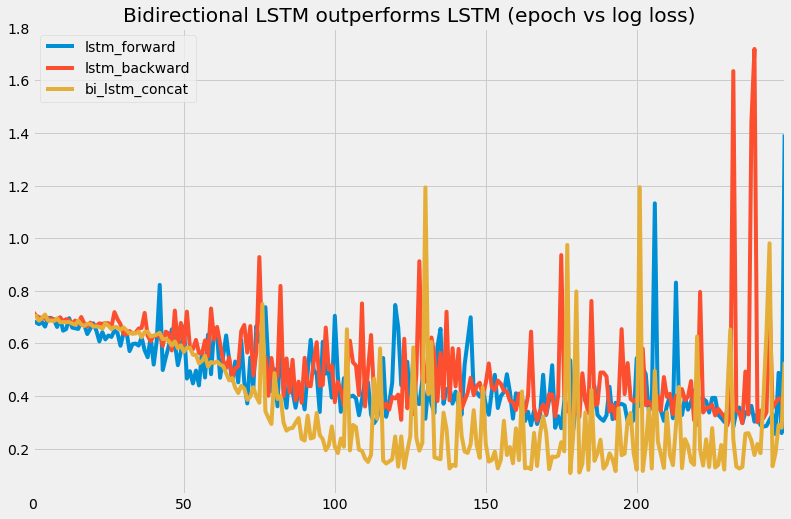

In [68]:
# Plot the results
results.plot(figsize=(12,8))
plt.title('Bidirectional LSTM outperforms LSTM (epoch vs log loss)')
plt.show()

Bidirectional LSTM (green) outperformed both LSTM forward (blue) and LSTM backward (orange) over 250 training epochs, with a faster log loss value decrease and overall lower value.

### Compare Bidirectional LSTM with different merge modes

Epoch 1/1
2s - loss: 0.6856 - acc: 0.5000
Epoch 1/1
0s - loss: 0.7019 - acc: 0.3000
Epoch 1/1
0s - loss: 0.6961 - acc: 0.5000
Epoch 1/1
0s - loss: 0.6967 - acc: 0.3000
Epoch 1/1
0s - loss: 0.6708 - acc: 0.8000
Epoch 1/1
0s - loss: 0.6713 - acc: 0.8000
Epoch 1/1
0s - loss: 0.6680 - acc: 0.8000
Epoch 1/1
0s - loss: 0.6883 - acc: 0.5000
Epoch 1/1
0s - loss: 0.6816 - acc: 0.6000
Epoch 1/1
0s - loss: 0.6635 - acc: 0.9000
Epoch 1/1
0s - loss: 0.6681 - acc: 0.9000
Epoch 1/1
0s - loss: 0.6833 - acc: 0.5000
Epoch 1/1
0s - loss: 0.6718 - acc: 0.9000
Epoch 1/1
0s - loss: 0.6720 - acc: 0.8000
Epoch 1/1
0s - loss: 0.6653 - acc: 0.9000
Epoch 1/1
0s - loss: 0.6758 - acc: 0.9000
Epoch 1/1
0s - loss: 0.6776 - acc: 0.7000
Epoch 1/1
0s - loss: 0.6520 - acc: 1.0000
Epoch 1/1
0s - loss: 0.6631 - acc: 0.9000
Epoch 1/1
0s - loss: 0.6668 - acc: 0.9000
Epoch 1/1
0s - loss: 0.6631 - acc: 0.9000
Epoch 1/1
0s - loss: 0.6588 - acc: 0.9000
Epoch 1/1
0s - loss: 0.6558 - acc: 1.0000
Epoch 1/1
0s - loss: 0.6566 - acc:

In [ ]:
results = DataFrame()

# Take the average of outputs
model = get_bi_lstm_model(n_timesteps, 'ave')
results['bi_lstm_ave'] = train_model(model, n_timesteps)

# Concatenate the outputs (passes double the number of outputs)
model = get_bi_lstm_model(n_timesteps, 'concat')
results['bi_lstm_concat'] = train_model(model, n_timesteps)

# Multiply the outputs
model = get_bi_lstm_model(n_timesteps, 'mul')
results['bi_lstm_mul'] = train_model(model, n_timesteps)

# Add the outputs
model = get_bi_lstm_model(n_timesteps, 'sum')
results['bi_lstm_sum'] = train_model(model, n_timesteps)

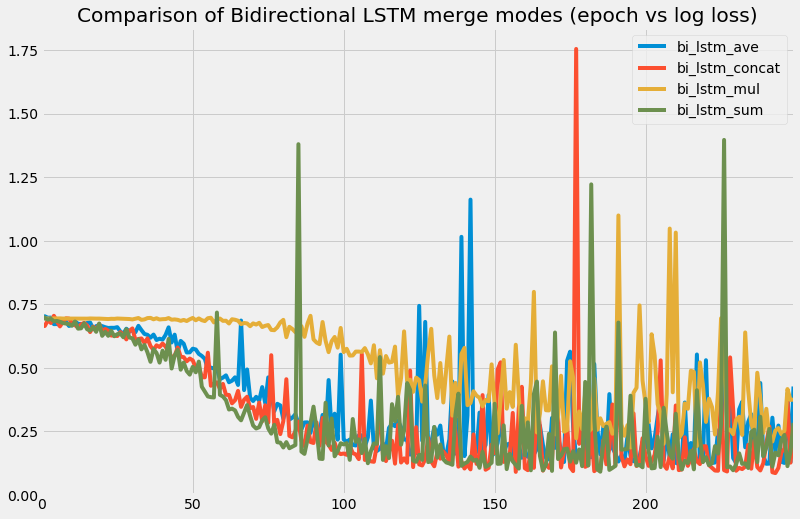

In [71]:
# Plot the results
results.plot(figsize=(12,8))
plt.title('Comparison of Bidirectional LSTM merge modes (epoch vs log loss)')
plt.show()

Concatenation (orange) and sum (red) merge modes displayed lower log loss. The effect of merge mode on model performance may vary depending on the specific sequence prediction problem being solved.